In [1]:
import torch
import os
import torchaudio
from torchaudio import datasets
import numpy as np

import torchaudio.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from torch.utils.data import random_split


import matplotlib.pyplot as plt
import librosa


### Load datasets

In [2]:
# Load dataset
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

In [3]:
train_dataset[0]

(tensor([[-0.0065, -0.0055, -0.0062,  ...,  0.0033,  0.0005, -0.0095]]),
 16000,
 'CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK',
 103,
 1240,
 0)

### Datasets Visualization
#### **Mel Spectogram**

In [4]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    """
    Plots the waveform of a audio signal.
    """
    waveform = np.array(waveform)

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    """
    Plots the spectrogram of a audio signal.
    """
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

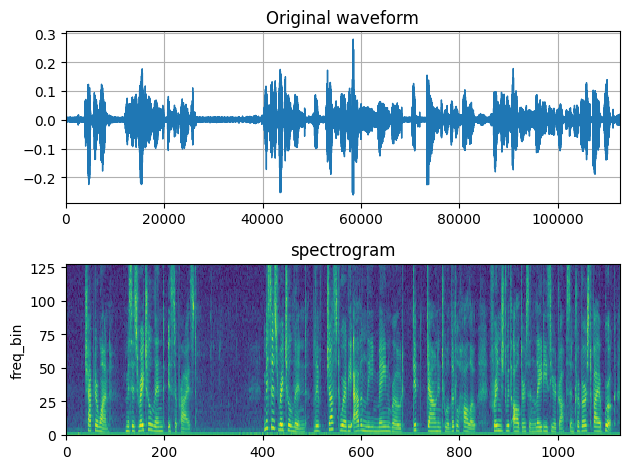

In [5]:
SAMPLE_RATE = 2

# Create function to transform
transform = T.MelSpectrogram(sample_rate=SAMPLE_RATE)

# Get first audio of the dataset to do test
first_audio = train_dataset[0][0]

# apply transformation
mel_Specgram = transform(first_audio)

fig, axs = plt.subplots(2, 1)
plot_waveform(first_audio, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(mel_Specgram[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

#### **MFCC**

CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK


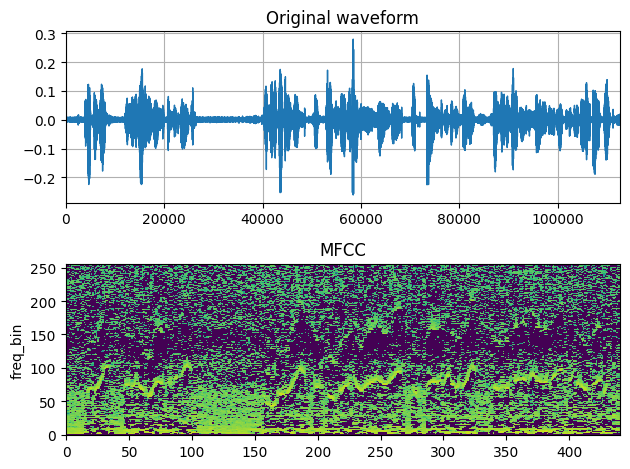

In [6]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(first_audio)

fig, axs = plt.subplots(2, 1)
plot_waveform(first_audio, SAMPLE_RATE, title="Original waveform", ax=axs[0])
plot_spectrogram(mfcc[0], title="MFCC", ax=axs[1])
fig.tight_layout()
print(train_dataset[0][2])

### Datasets Processing
##### **Define metrics functions**

In [7]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """
    This method calculates the levenshtein distance between a reference string and a hypothesis string.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """
    This method calculates the word error rate between a reference string and a hypothesis string.
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """
    This method calculates the char error rate between a reference string and a hypothesis string.
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """
    This method calculates the word error rate between a reference string and a hypothesis string.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """
    This method calculates the char error rate between a reference string and a hypothesis string.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer



/home/djulo/Source/Epita/reco_parole/project/venv/lib64/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


##### **Define preprocessing functions**

Basically, we want to convert sequence of char into sequence of int and use padding to get sequence of same length

In [ ]:
char_map_str = """
' 0
<SPACE> 1
a 2
b 3
c 4
d 5
e 6
f 7
g 8
h 9
i 10
j 11
k 12
l 13
m 14
n 15
o 16
p 17
q 18
r 19
s 20
t 21
u 22
v 23
w 24
x 25
y 26
z 27
"""

class TextTransform:
    """
    Maps characters to integers and vice versa
    """

    def __init__(self):
        self.char_map_str = char_map_str
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """
        Converts a string to its character integer representation.
        """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence
    
    def int_to_text(self, labels) -> list:
        """
        Converts an integer label to its string representation.
        """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('', ' ')
    
train_audio_transforms = nn.Sequential(
    T.MelSpectrogram(sample_rate=16000, n_mels=128),
    T.FrequencyMasking(freq_mask_param=15), # Data Augmentation
    T.TimeMasking(time_mask_param=35) # Data Augmentation
)

valid_audio_transforms = T.MelSpectrogram()
text_transform = TextTransform()

def data_processing(data, data_type="train"):
    """
    Apply transformation to the data and process it to be ready to use.
    """
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths

### Model Training

We use a Greedy decoder for simplicity.

In [9]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    """
    Decodes the output of the model.
    """
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

In [10]:
def train(model, device, train_loader, criterion, optimizer, scheduler, epoch):
    """
    Train the model.
    """
    model.train()
    data_len = len(train_loader.dataset)
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(spectrograms), data_len, 100. * batch_idx / len(train_loader), loss.item()))


In [11]:
def test(model, device, test_loader, criterion):
    """
    Test the model.
    """
    print('\nevaluating…')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for I, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))

For now, we choose arbitrarily the HyperParameters

In [12]:
N_CNN_LAYERS = 3
N_RNN_LAYERS = 5
RNN_DIM = 512

N_CLASS = 29
N_FEATS = 128

HIDDEN_SIZE = 128
STRIDE = 2
DROPOUT = 0.1

LEARNING_RATE = 5e-4
BATCH_SIZE = 20
EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [14]:
def main(train_dataset, test_dataset, model):
    """
    Main function to apply all the steps.
    """
    torch.manual_seed(0)

    if not os.path.isdir("./data"):
        os.makedirs("./data")

    train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: data_processing(x, 'train'))
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: data_processing(x, 'valid'))

    print(model)
    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), LEARNING_RATE)
    criterion = nn.CTCLoss(blank=28).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=EPOCHS,
                                            anneal_strategy='linear')

    for epoch in range(1, EPOCHS + 1):
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch)
        test(model, device, test_loader, criterion, epoch)


# We use only 5% of the dataset to train faster
subset_size_train = int(0.05 * len(train_dataset))
train_dataset_subset, _ = random_split(train_dataset, [subset_size_train, len(train_dataset) - subset_size_train])

subset_size_test = int(0.05 * len(test_dataset))
test_dataset_subset, _ = random_split(test_dataset, [subset_size_test, len(test_dataset) - subset_size_test])

##### **Simple MLP**

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, n_feats, hidden_size, num_classes):
        super(SimpleMLP, self).__init__()
        n_feats = n_feats//2
        self.fc1 = nn.Linear(hidden_size, hidden_size*2)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])
        x = x.transpose(1, 2)
        x = self.fc1(x)

        x = self.classifier(x)
        return x

In [15]:
model = SimpleMLP(n_feats=N_FEATS, hidden_size=HIDDEN_SIZE, num_classes=N_CLASS).to(device)

main(train_dataset=train_dataset_subset, test_dataset=test_dataset_subset, model=model)

SimpleMLP(
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=29, bias=True)
  )
)
Num Model Parameters 69661
Train Epoch: 1 [0/1426 (0%)]	Loss: 7.267455

evaluating…
Test set: Average loss: 4.8365, Average CER: 0.772086 Average WER: 0.9156

Train Epoch: 2 [0/1426 (0%)]	Loss: 4.440255

evaluating…
Test set: Average loss: 3.9524, Average CER: 0.999772 Average WER: 0.9735

Train Epoch: 3 [0/1426 (0%)]	Loss: 3.835356

evaluating…
Test set: Average loss: 3.4663, Average CER: 1.000000 Average WER: 0.9737

Train Epoch: 4 [0/1426 (0%)]	Loss: 3.184218

evaluating…
Test set: Average loss: 3.2046, Average CER: 0.999723 Average WER: 0.9734

Train Epoch: 5 [0/1426 (0%)]	Loss: 3.022490

evaluating…
Test set: Average loss: 3.0816, Average CER: 0.999475 Average WER: 0.9730

Train Epoch: 6 [0/1426 (0%)]	Loss: 2.947628

eval

##### **bi-GRU model**

In [17]:
class CNNLayerNorm(nn.Module):
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 

class ResidualCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)
        
class BidirectionalGRU(nn.Module):
    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [18]:
model_gru = SpeechRecognitionModel(N_CNN_LAYERS, N_RNN_LAYERS, RNN_DIM, N_CLASS, N_FEATS, STRIDE, DROPOUT).to(device)

main(train_dataset=train_dataset_subset, test_dataset=test_dataset_subset, model=model_gru)

SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((64,),

KeyboardInterrupt: 